In [4]:
import pandas as pd
import numpy as np
import requests, zipfile, io, warnings
from dfply import *
warnings.filterwarnings("ignore")

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
r = requests.get(url, timeout=60)
zf = zipfile.ZipFile(io.BytesIO(r.content))
with zf.open("student-mat.csv") as f:
    student_data = pd.read_csv(f, sep=";")
print(student_data.shape)


(395, 33)


In [6]:
from dfply import X

student = (student_data
    >> mutate(
        alcohol_involvement = (X.Dalc + X.Walc) / 2,
        low_failures = 4 - X.failures,
        socializing_risk = (X.Dalc + X.Walc + X.goout) / 3
    )
)

print(student[["alcohol_involvement","socializing_risk","low_failures"]].describe())

       alcohol_involvement  socializing_risk  low_failures
count           395.000000        395.000000    395.000000
mean              1.886076          2.293671      3.665823
std               0.992195          0.876369      0.743651
min               1.000000          1.000000      1.000000
25%               1.000000          1.666667      4.000000
50%               1.500000          2.000000      4.000000
75%               2.500000          2.666667      4.000000
max               5.000000          5.000000      4.000000


In [9]:
def spearman_brown(r):
    if pd.isna(r): return np.nan
    return (2*r)/(1+r)

r_alc = student["Dalc"].corr(student["Walc"], method="spearman")
sb_alc = spearman_brown(r_alc)
print(f"Alcohol involvement: r={r_alc:.3f}, SB={sb_alc:.3f}")


Alcohol involvement: r=0.640, SB=0.780


In [7]:
def spearman_brown(r):
    if pd.isna(r): return np.nan
    return (2*r)/(1+r)

r_alc = student["Dalc"].corr(student["Walc"], method="spearman")
sb_alc = spearman_brown(r_alc)
print(f"Alcohol involvement: r={r_alc:.3f}, SB={sb_alc:.3f}")


Alcohol involvement: r=0.640, SB=0.780


In [8]:
def spearman_alpha(df_items):
    R = df_items.rank().corr(method="spearman")
    k = R.shape[0]
    return (k/(k-1))*(1 - np.trace(R.values)/R.values.sum())

risk3 = student[["Dalc","Walc","goout"]]
alpha_ord = spearman_alpha(risk3)
print(f"Socializing risk ordinal alpha = {alpha_ord:.3f}")


Socializing risk ordinal alpha = 0.693


In [9]:
def group_sb(df, group_col):
    rows = []
    for g, d in df.groupby(group_col):
        r = d['Dalc'].corr(d['Walc'], method='spearman')
        sb = spearman_brown(r)
        rows.append({group_col: g, 'rho_SB': sb, 'n': len(d)})
    return pd.DataFrame(rows)

print(group_sb(student, 'sex'))


  sex    rho_SB    n
0   F  0.705025  208
1   M  0.814338  187


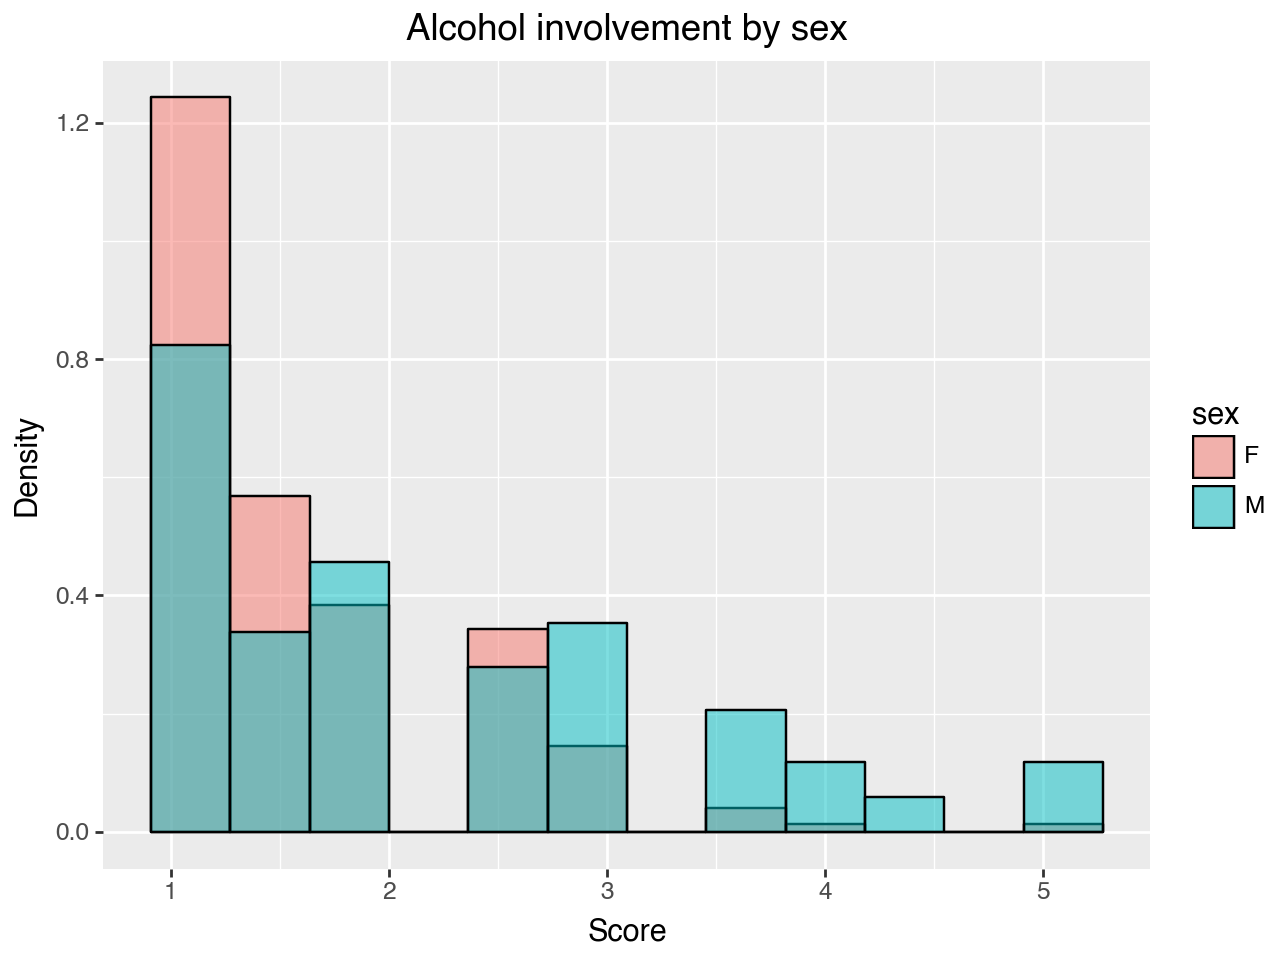

In [10]:
from plotnine import *

(ggplot(student, aes(x="alcohol_involvement", fill="sex"))
 + geom_histogram(aes(y="..density.."), bins=12, alpha=0.5, color="black", position="identity")
 + labs(title="Alcohol involvement by sex", x="Score", y="Density")
 + theme(legend_position="right"))
